In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from IPython.display import display

from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectPercentile, chi2, f_classif

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    precision_score,
    recall_score,
)


In [3]:
dataset = "./date_tema_1_iaut_2024.csv"
df = pd.read_csv(dataset)
df.head()

,Transportation,Regular_fiber_diet,Diagnostic_in_family_history,High_calorie_diet,Sedentary_hours_daily,Age,Alcohol,Est_avg_calorie_intake,Main_meals_daily,Snacks,Height,Smoker,Water_daily,Calorie_monitoring,Weight,Physical_activity_level,Technology_time_use,Gender,Diagnostic
0,Public_Transportation,2,yes,no,"3,73",21,no,2474,3,Sometimes,"1,62",no,2,no,64,0,1,Female,D1
1,Public_Transportation,3,yes,no,"2,92",21,Sometimes,2429,3,Sometimes,"1,52",yes,3,yes,56,3,0,Female,D1
2,Public_Transportation,2,yes,no,"3,85",23,Frequently,2656,3,Sometimes,"1,8",no,2,no,77,2,1,Male,D1
3,Walking,3,no,no,"3,01",27,Frequently,2260,3,Sometimes,"1,8",no,2,no,-1,2,0,Male,D2
4,Public_Transportation,2,no,no,"2,73",22,Sometimes,1895,1,Sometimes,"1,78",no,2,no,"89,8",0,0,Male,D3


In [53]:
categorical_features = [
    "Transportation",
    "Diagnostic_in_family_history",
    "High_calorie_diet",
    "Alcohol",
    "Snacks",
    "Smoker",
    "Calorie_monitoring",
    "Gender"
]

numeric_features = [
    "Regular_fiber_diet",
    "Sedentary_hours_daily",
    "Age",
    "Est_avg_calorie_intake",
    "Main_meals_daily",
    "Height",
    "Water_daily",
    "Weight",
    "Physical_activity_level",
    "Technology_time_use",
]

for col in numeric_features:
    df[col] = df[col].astype(str).str.replace(',', '.').astype(float)
for col in categorical_features:
    df[col] = df[col].astype("category")

In [61]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


print("Dimensiunea x_train:", x_train.shape)
print("Dimensiunea y_train:", y_train.shape)
print("Dimensiunea x_test:", x_test.shape)
print("Dimensiunea y_test:", y_test.shape)

Dimensiunea x_train: (1536, 18)
Dimensiunea y_train: (1536,)
Dimensiunea x_test: (385, 18)
Dimensiunea y_test: (385,)


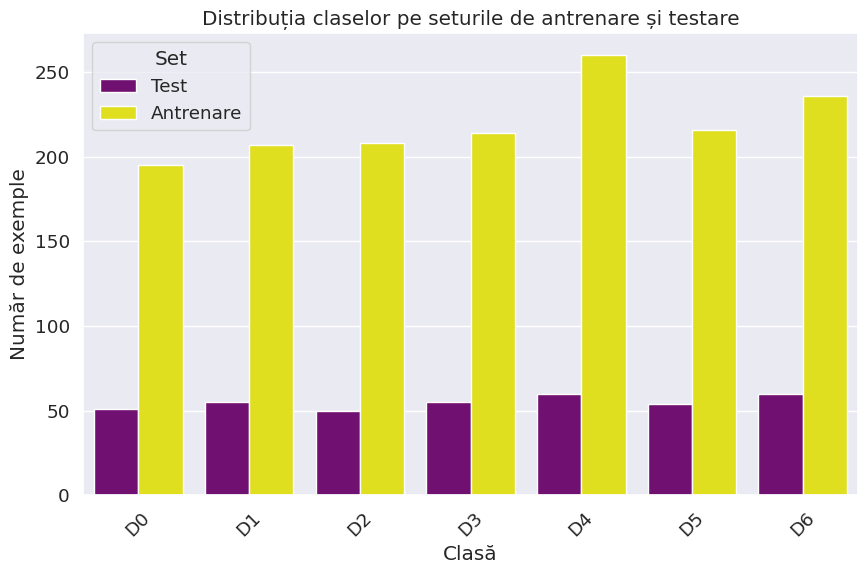

In [55]:
train_df = pd.DataFrame({'Clasă': y_train, 'Set': 'Antrenare'})
test_df = pd.DataFrame({'Clasă': y_test, 'Set': 'Test'})

combined_df = pd.concat([train_df, test_df])

# Ordonarea claselor alfabetic
combined_df['Clasă'] = combined_df['Clasă'].astype(str)
combined_df = combined_df.sort_values('Clasă')

custom_palette = sns.color_palette(['purple', 'yellow'])

plt.figure(figsize=(10, 6))
sns.countplot(data=combined_df, x='Clasă', hue='Set', palette=custom_palette)
plt.title('Distribuția claselor pe seturile de antrenare și testare')
plt.xlabel('Clasă')
plt.ylabel('Număr de exemple')
plt.legend(title='Set')
plt.xticks(rotation=45)
plt.show()

In [56]:
# Calcularea valorilor statistice pentru atributele numerice, incluzând și statistici suplimentare
numeric_stats = df[numeric_features].agg(['mean', 'std', 'median', 'min', 'max', 'ptp', 'quantile', lambda x: x.quantile(0.75) - x.quantile(0.25)]).transpose()

# Calcularea Abaterii Medii Absolută pe fiecare coloană
mad_values = df[numeric_features].apply(lambda x: np.mean(np.abs(x - np.mean(x))), axis=0)
numeric_stats['Abaterea medie absolută'] = mad_values

# Redenumirea coloanelor și eliminarea spațiului pentru a se potrivi cu numărul de coloane
numeric_stats.columns = ['Medie', 'Abaterea standard', 'Mediană', 'Valoare minimă', 'Valoare maximă', 'Interval intercuartil', 'Abaterea medie absolută', 'Diferența de valori maxime și minime', 'Intervalul intercuartil']
numeric_stats = numeric_stats[['Medie', 'Abaterea standard', 'Mediană', 'Valoare minimă', 'Valoare maximă', 'Diferența de valori maxime și minime', 'Abaterea medie absolută', 'Interval intercuartil']]

print("Valori statistice pentru atributele numerice:")
# print(numeric_stats)
for col in numeric_features:
    col_data = df[col]
    col_mean = col_data.mean()
    col_std = col_data.std()
    col_min = col_data.min()
    col_max = col_data.max()
    col_ptp = col_max - col_min
    col_median = col_data.median()
    col_iqr = col_data.quantile(0.75) - col_data.quantile(0.25)
    col_mad = np.mean(np.abs(col_data - np.mean(col_data)))
    col_mad_median = np.median(np.abs(col_data - col_median))

    print(f"Coloana: {col}")
    print(f"Medie: {col_mean}")
    print(f"Abaterea medie absolută: {col_mad}")
    print(f"Abatere standard: {col_std}")
    print(f"Valoare minimă: {col_min}")
    print(f"Valoare maximă: {col_max}")
    print(f"Diferența de valori maxime și minime: {col_ptp}")
    print(f"Mediană: {col_median}")
    print(f"Abaterea mediană absolută: {col_mad_median}")
    print(f"Interval intercuartil: {col_iqr}")
    print("\n")



Valori statistice pentru atributele numerice:
Coloana: Regular_fiber_diet
Medie: 3.8449373862571576
Abaterea medie absolută: 2.8476367127680824
Abatere standard: 62.4396174995684
Valoare minimă: 1.0
Valoare maximă: 2739.0
Diferența de valori maxime și minime: 2738.0
Mediană: 2.387426
Abaterea mediană absolută: 0.38742600000000005
Interval intercuartil: 1.0


Coloana: Sedentary_hours_daily
Medie: 3.693571056741281
Abaterea medie absolută: 1.1338850443643116
Abatere standard: 21.759834908880748
Valoare minimă: 2.21
Valoare maximă: 956.58
Diferența de valori maxime și minime: 954.37
Mediană: 3.13
Abaterea mediană absolută: 0.43999999999999995
Interval intercuartil: 0.8700000000000001


Coloana: Age
Medie: 44.79250626392504
Abaterea medie absolută: 40.94688616864699
Abatere standard: 633.3118370767136
Valoare minimă: 15.0
Valoare maximă: 19685.0
Diferența de valori maxime și minime: 19670.0
Mediană: 22.829753
Abaterea mediană absolută: 3.170247
Interval intercuartil: 6.02834


Coloana: Est

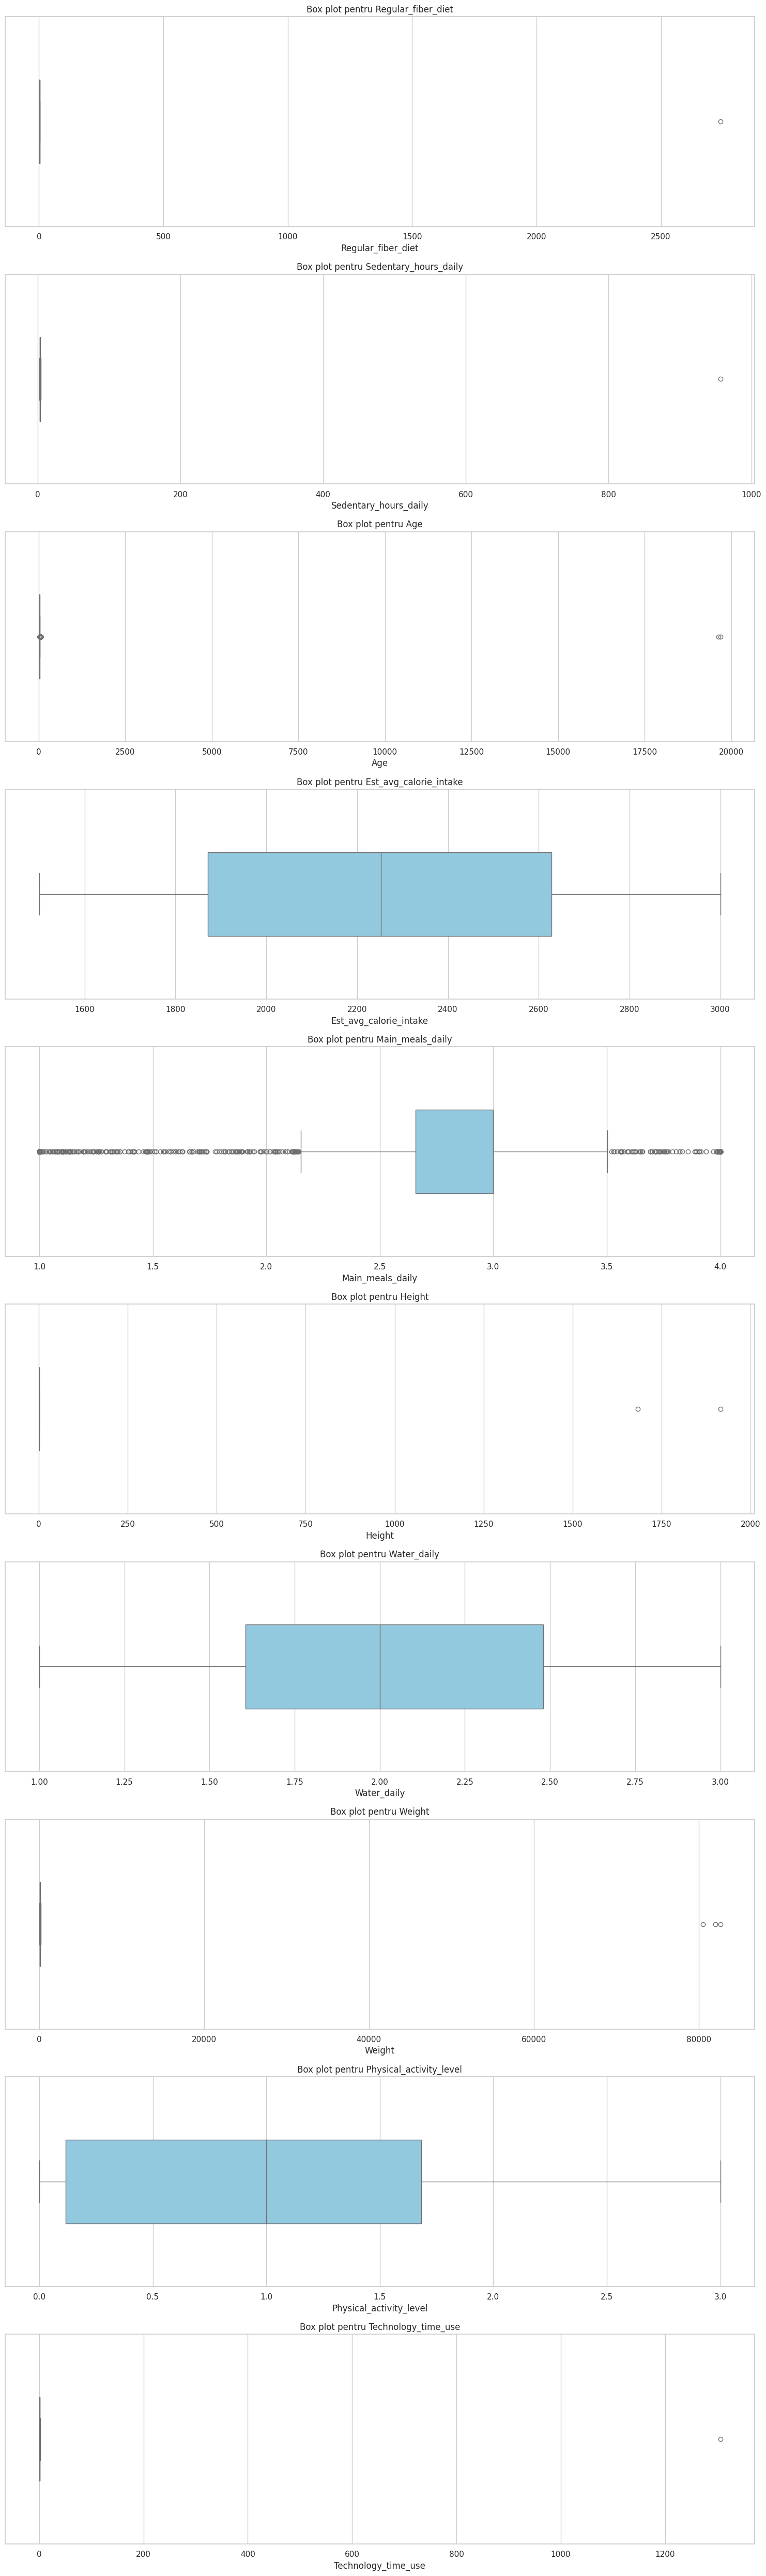

In [57]:
sns.set(style="whitegrid")

num_cols = len(numeric_features)

plt.figure(figsize=(15, 5*num_cols))

for i, col in enumerate(numeric_features):
    plt.subplot(num_cols, 1, i+1)
    sns.boxplot(x=df[col], width=0.4, color='skyblue')
    plt.title(f'Box plot pentru {col}')
    plt.xlabel(col)

plt.tight_layout()
plt.show()


Valori statistice pentru atributele numerice (fără outlier-e):
Coloana: Regular_fiber_diet
Medie: 2.4203774578124997
Abaterea medie absolută: 0.47815110502604163
Abatere standard: 0.5332075570365954
Valoare minimă: 1.0
Valoare maximă: 3.0
Diferența de valori maxime și minime: 2.0
Mediană: 2.386464
Abaterea mediană absolută: 0.38646400000000014
Interval intercuartil: 1.0


Coloana: Sedentary_hours_daily
Medie: 3.1972760416666666
Abaterea medie absolută: 0.4707763834635416
Abatere standard: 0.5757556394708153
Valoare minimă: 2.21
Valoare maximă: 4.67
Diferența de valori maxime și minime: 2.46
Mediană: 3.13
Abaterea mediană absolută: 0.43999999999999995
Interval intercuartil: 0.8700000000000001


Coloana: Age
Medie: 24.35351981917665
Abaterea medie absolută: 4.812856826384681
Abatere standard: 6.409236013781201
Valoare minimă: 15.0
Valoare maximă: 61.0
Diferența de valori maxime și minime: 46.0
Mediană: 22.829681
Abaterea mediană absolută: 3.170318999999999
Interval intercuartil: 6.032935

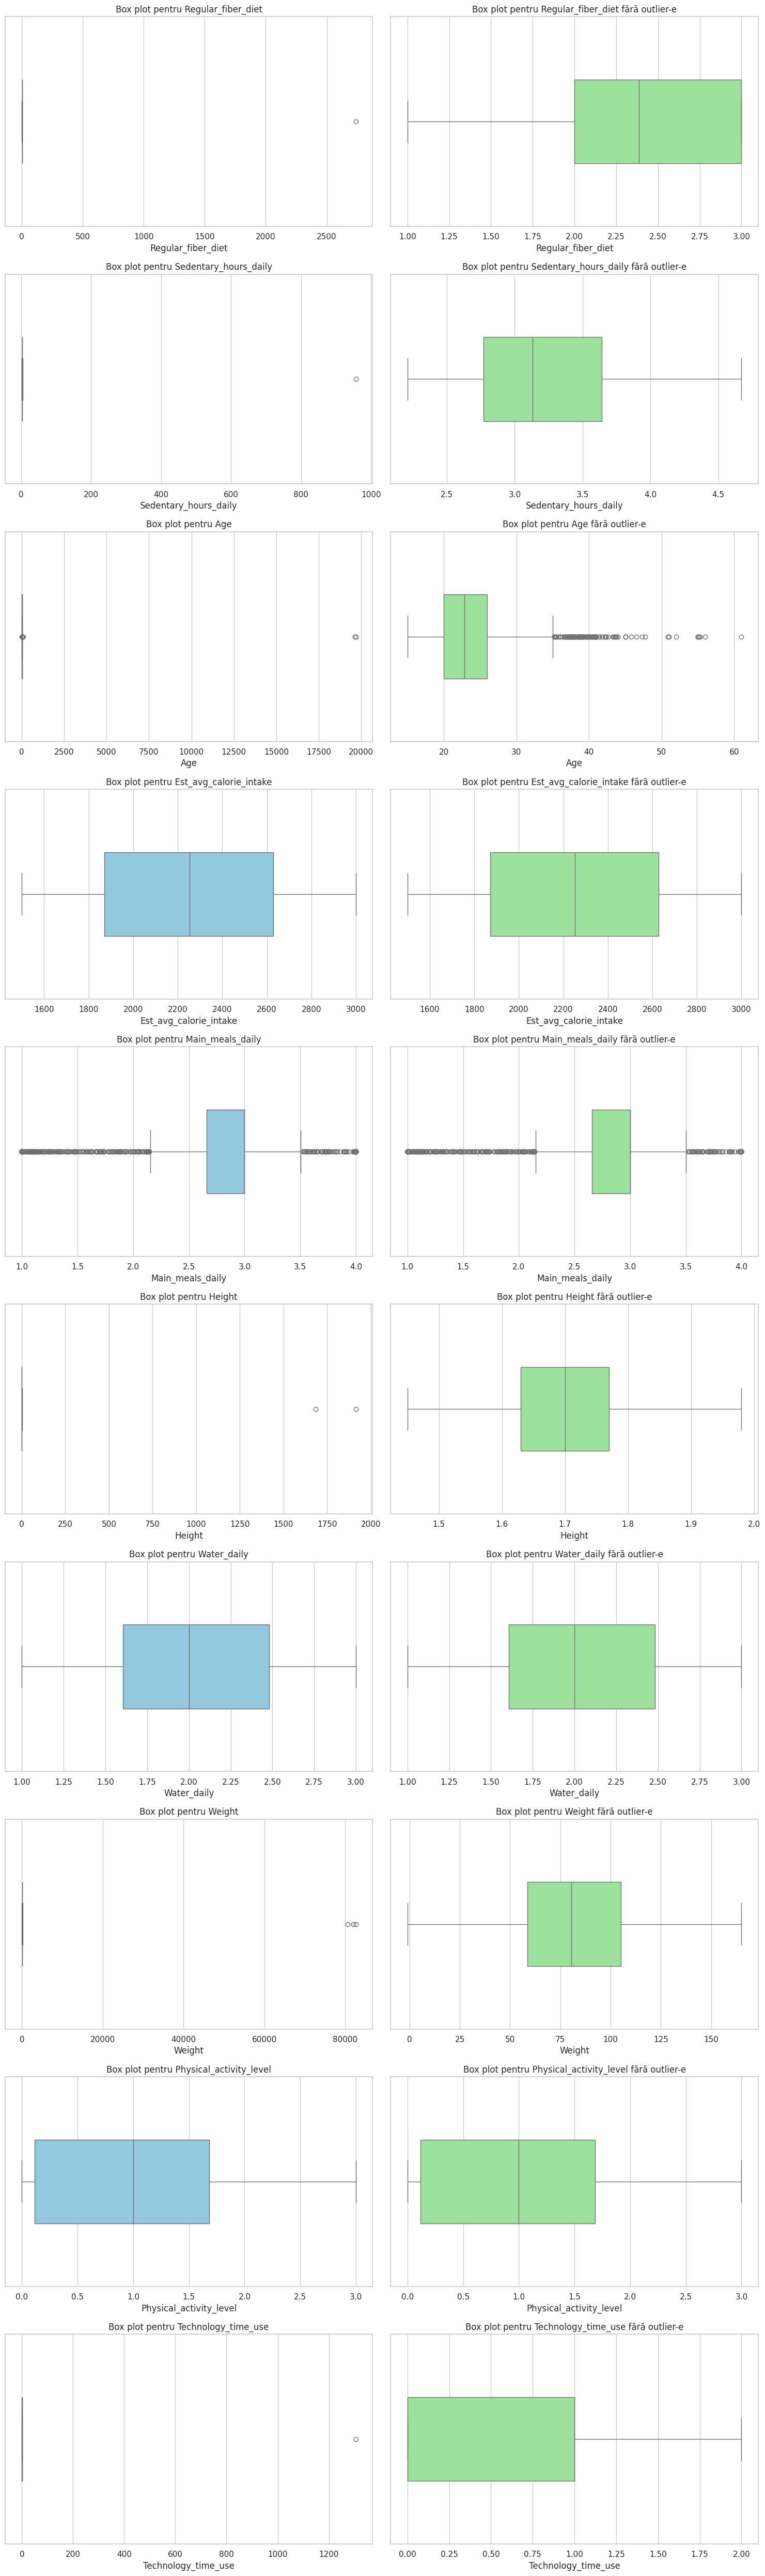

In [58]:

# Funcție pentru identificarea outlier-elor folosind z-scores
def remove_outliers(data):
    z_scores = stats.zscore(data)
    return data[(z_scores < 3) & (z_scores > -3)]

# Funcție pentru a crea box plot-uri pentru atributele numerice
def plot_boxplots(df, numeric_features):
    sns.set(style="whitegrid")

    num_cols = len(numeric_features)

    plt.figure(figsize=(15, 5*num_cols))

    for i, col in enumerate(numeric_features):
        plt.subplot(num_cols, 2, 2*i+1)
        sns.boxplot(x=df[col], width=0.4, color='skyblue')
        plt.title(f'Box plot pentru {col}')
        plt.xlabel(col)

        plt.subplot(num_cols, 2, 2*i+2)
        col_data_no_outliers = remove_outliers(df[col])

        sns.boxplot(x=col_data_no_outliers, width=0.4, color='lightgreen')
        plt.title(f'Box plot pentru {col} fără outlier-e')
        plt.xlabel(col)

    plt.tight_layout()
    plt.show()

# Afișăm statisticile și box plot-urile
print("Valori statistice pentru atributele numerice (fără outlier-e):")
for col in numeric_features:

    col_data_no_outliers = remove_outliers(df[col])

    col_mean_no_outliers = col_data_no_outliers.mean()
    col_std_no_outliers = col_data_no_outliers.std()
    col_min_no_outliers = col_data_no_outliers.min()
    col_max_no_outliers = col_data_no_outliers.max()
    col_ptp_no_outliers = col_max_no_outliers - col_min_no_outliers
    col_median_no_outliers = col_data_no_outliers.median()
    col_iqr_no_outliers = col_data_no_outliers.quantile(0.75) - col_data_no_outliers.quantile(0.25)
    col_mad_no_outliers = np.mean(np.abs(col_data_no_outliers - np.mean(col_data_no_outliers)))
    col_mad_median_no_outliers = np.median(np.abs(col_data_no_outliers - col_median_no_outliers))

    print(f"Coloana: {col}")
    print(f"Medie: {col_mean_no_outliers}")
    print(f"Abaterea medie absolută: {col_mad_no_outliers}")
    print(f"Abatere standard: {col_std_no_outliers}")
    print(f"Valoare minimă: {col_min_no_outliers}")
    print(f"Valoare maximă: {col_max_no_outliers}")
    print(f"Diferența de valori maxime și minime: {col_ptp_no_outliers}")
    print(f"Mediană: {col_median_no_outliers}")
    print(f"Abaterea mediană absolută: {col_mad_median_no_outliers}")
    print(f"Interval intercuartil: {col_iqr_no_outliers}")
    print("\n")

# Afișăm box plot-urile
plot_boxplots(df, numeric_features)


Valori unice pentru atributele categorice:
Transportation                  5
Diagnostic_in_family_history    2
High_calorie_diet               2
Alcohol                         4
Snacks                          4
Smoker                          2
Calorie_monitoring              2
Gender                          2
dtype: int64


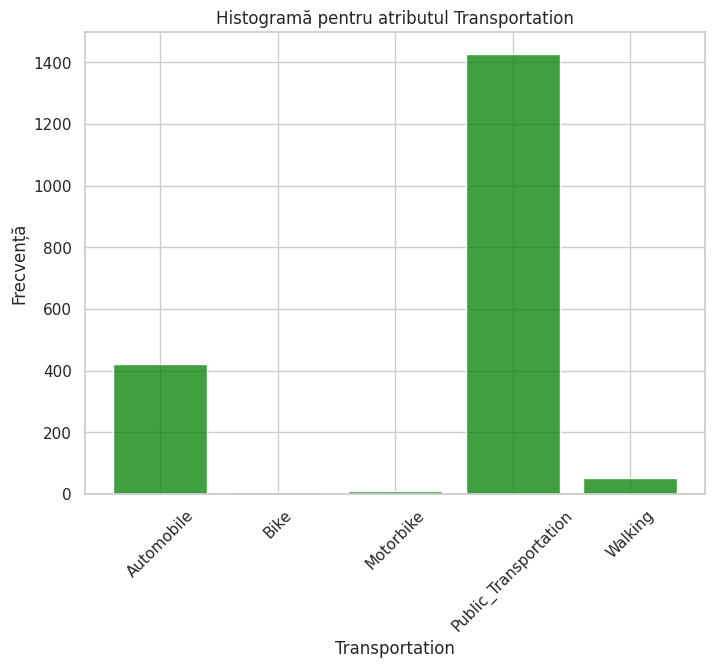

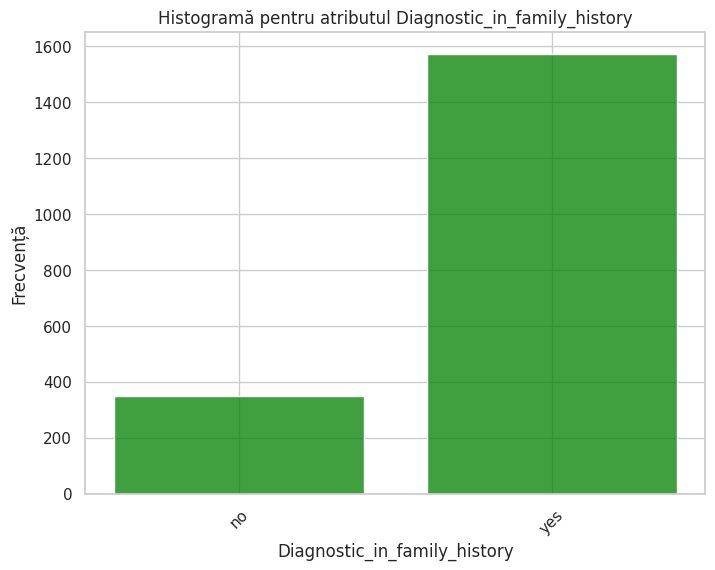

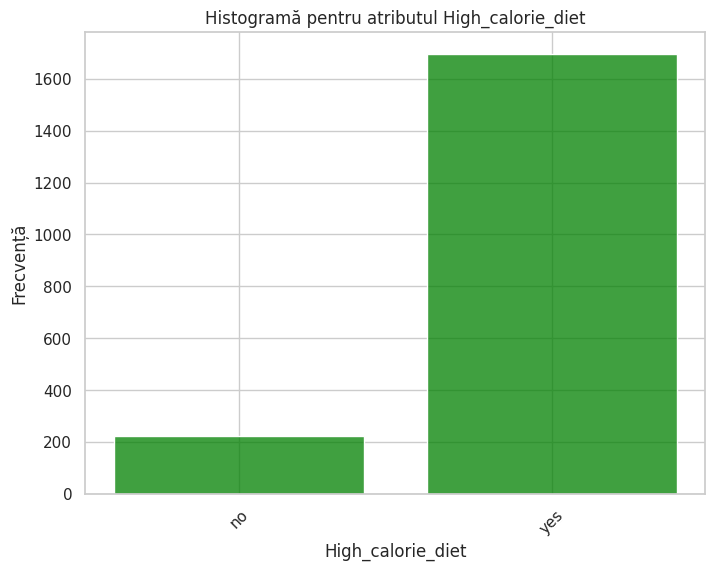

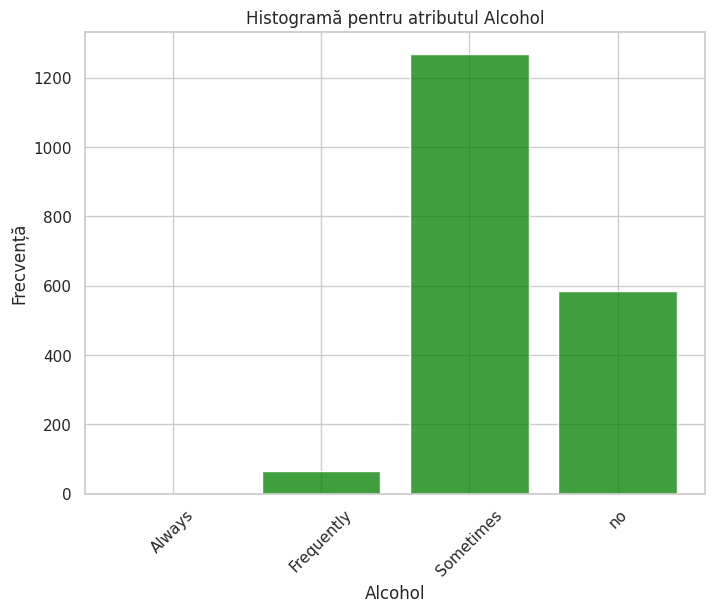

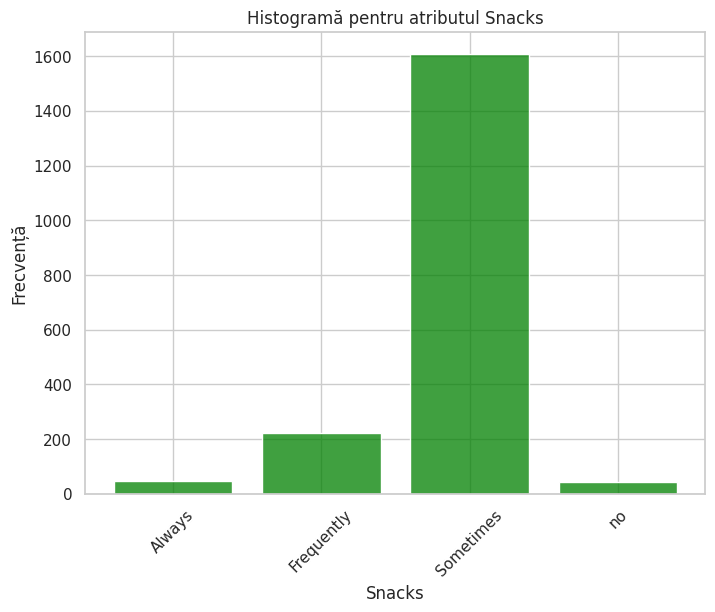

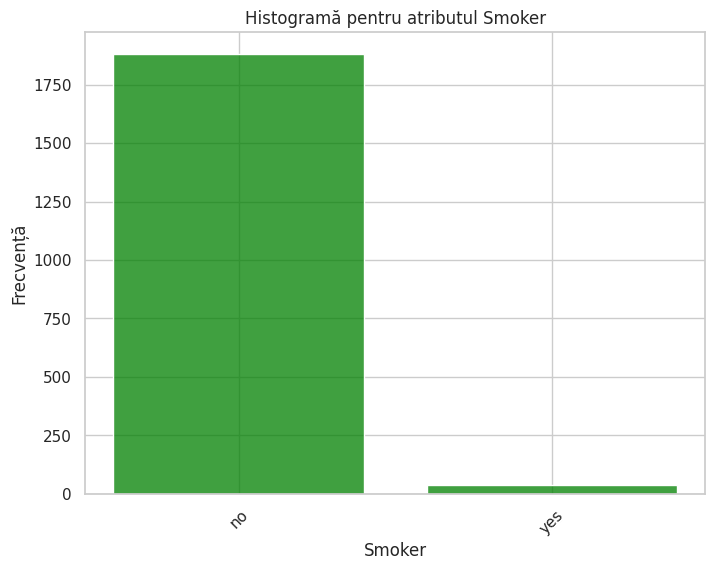

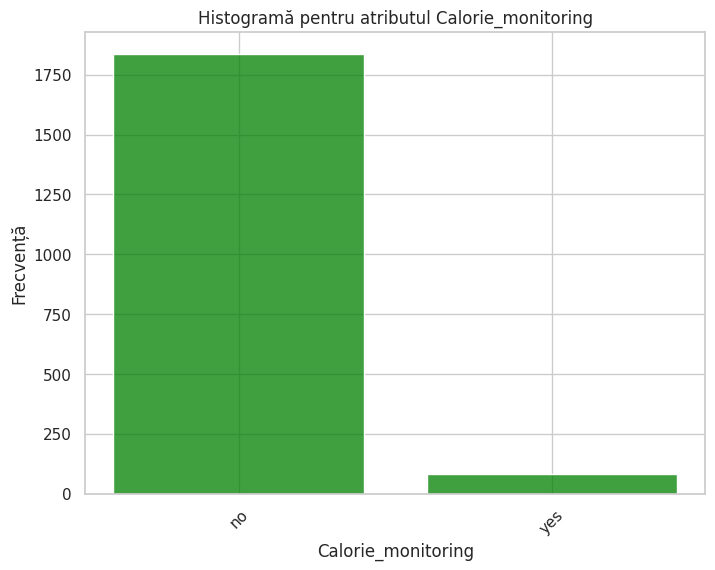

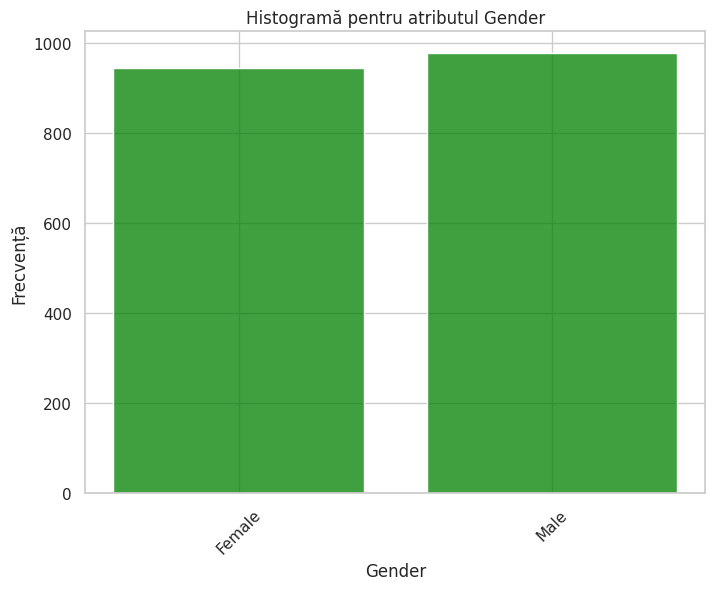

In [59]:
categorical_unique = df[categorical_features].nunique()
print("Valori unice pentru atributele categorice:")
print(categorical_unique)

for col in categorical_features:
    plt.figure(figsize=(8, 6))
    sns.histplot(data=df, x=col, discrete=True, multiple="dodge", shrink=0.8, color='green')
    plt.title(f'Histogramă pentru atributul {col}')
    plt.xlabel(col)
    plt.ylabel('Frecvență')
    plt.xticks(rotation=45)
    plt.show()

In [64]:
for col in categorical_features:
    df[col] = df[col].astype("category").cat.codes

df["Diagnostic"] = df["Diagnostic"].astype("category").cat.codes
cov_matrix = df.cov()

display(cov_matrix)



,Transportation,Regular_fiber_diet,Diagnostic_in_family_history,High_calorie_diet,Sedentary_hours_daily,Age,Alcohol,Est_avg_calorie_intake,Main_meals_daily,Snacks,Height,Smoker,Water_daily,Calorie_monitoring,Weight,Physical_activity_level,Technology_time_use,Gender,Diagnostic
Transportation,1.613173,0.965563,-0.048862,-0.029535,0.422834,8.339901,-0.015630,8.080411,-0.049460,-0.026046,1.200332,-0.001645,0.040653,0.008656,8.296457e+01,0.013698,0.585394,-0.087938,0.031402
Regular_fiber_diet,0.965563,3898.705833,0.267044,0.162319,-2.044016,-28.298519,-0.402042,-411.186479,0.098487,0.190270,-2.769186,-0.028356,-0.239886,-0.054207,-1.358114e+02,0.128235,-2.233738,0.626906,2.914826
Diagnostic_in_family_history,-0.048862,0.267044,0.148416,0.024699,0.094913,4.201033,0.006592,-6.864424,0.020677,0.031439,0.347992,0.000649,0.036532,-0.012481,2.777532e+01,-0.017956,0.129837,0.019265,0.385575
High_calorie_diet,-0.029535,0.162319,0.024699,0.103063,0.071932,2.513981,-0.014435,2.786477,-0.001555,0.021901,0.223678,-0.002779,0.002342,-0.012147,1.686162e+01,-0.029297,0.092410,0.010898,0.154993
Sedentary_hours_daily,0.422834,-2.044016,0.094913,0.071932,473.490415,-13.086870,0.376236,273.718418,-0.611959,0.062952,-0.587676,-0.009673,-0.071017,-0.023988,1.916370e+01,-0.476095,648.167098,-0.252078,-0.637862
Age,8.339901,-28.298519,4.201033,2.513981,-13.086870,401083.882981,-5.636496,-88.784631,18.484813,3.154728,-34.922604,-0.343318,10.450899,-1.015785,-2.773866e+03,19.992288,-22.876826,10.204190,-19.335636
Alcohol,-0.015630,-0.402042,0.006592,-0.014435,0.376236,-5.636496,0.268677,-0.293501,-0.030439,-0.011072,-0.510293,-0.006128,-0.031022,-0.000697,4.909831e+01,0.036450,0.509009,0.002635,-0.154355
Est_avg_calorie_intake,8.080411,-411.186479,-6.864424,2.786477,273.718418,-88.784631,-0.293501,188421.795103,-4.573814,0.611156,-930.357530,-2.613285,-4.249024,-1.236498,-2.045723e+04,-1.738810,371.218433,-5.736378,-32.980618
Main_meals_daily,-0.049460,0.098487,0.020677,-0.001555,-0.611959,18.484813,-0.030439,-4.573814,0.607120,-0.033477,0.611016,0.001386,0.032494,-0.000350,-3.808376e-01,0.095262,-0.844501,0.029704,0.040006
Snacks,-0.026046,0.190270,0.031439,0.021901,0.062952,3.154728,-0.011072,0.611156,-0.033477,0.217145,0.269326,-0.004320,0.043916,-0.010501,2.154517e+01,-0.010111,0.083182,0.021538,0.301313


from matplotlib import pyplot as plt
cov_matrix['Transportation'].plot(kind='hist', bins=20, title='Transportation')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
cov_matrix['Regular_fiber_diet'].plot(kind='hist', bins=20, title='Regular_fiber_diet')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
cov_matrix['Diagnostic_in_family_history'].plot(kind='hist', bins=20, title='Diagnostic_in_family_history')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
cov_matrix['High_calorie_diet'].plot(kind='hist', bins=20, title='High_calorie_diet')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
cov_matrix.plot(kind='scatter', x='Transportation', y='Regular_fiber_diet', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
cov_matrix.plot(kind='scatter', x='Regular_fiber_diet', y='Diagnostic_in_family_history', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
cov_matrix.plot(kind='scatter', x='Diagnostic_in_family_history', y='High_calorie_diet', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
cov_matrix.plot(kind='scatter', x='High_calorie_diet', y='Sedentary_hours_daily', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
cov_matrix['Transportation'].plot(kind='line', figsize=(8, 4), title='Transportation')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
cov_matrix['Regular_fiber_diet'].plot(kind='line', figsize=(8, 4), title='Regular_fiber_diet')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
cov_matrix['Diagnostic_in_family_history'].plot(kind='line', figsize=(8, 4), title='Diagnostic_in_family_history')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
cov_matrix['High_calorie_diet'].plot(kind='line', figsize=(8, 4), title='High_calorie_diet')
plt.gca().spines[['top', 'right']].set_visible(False)

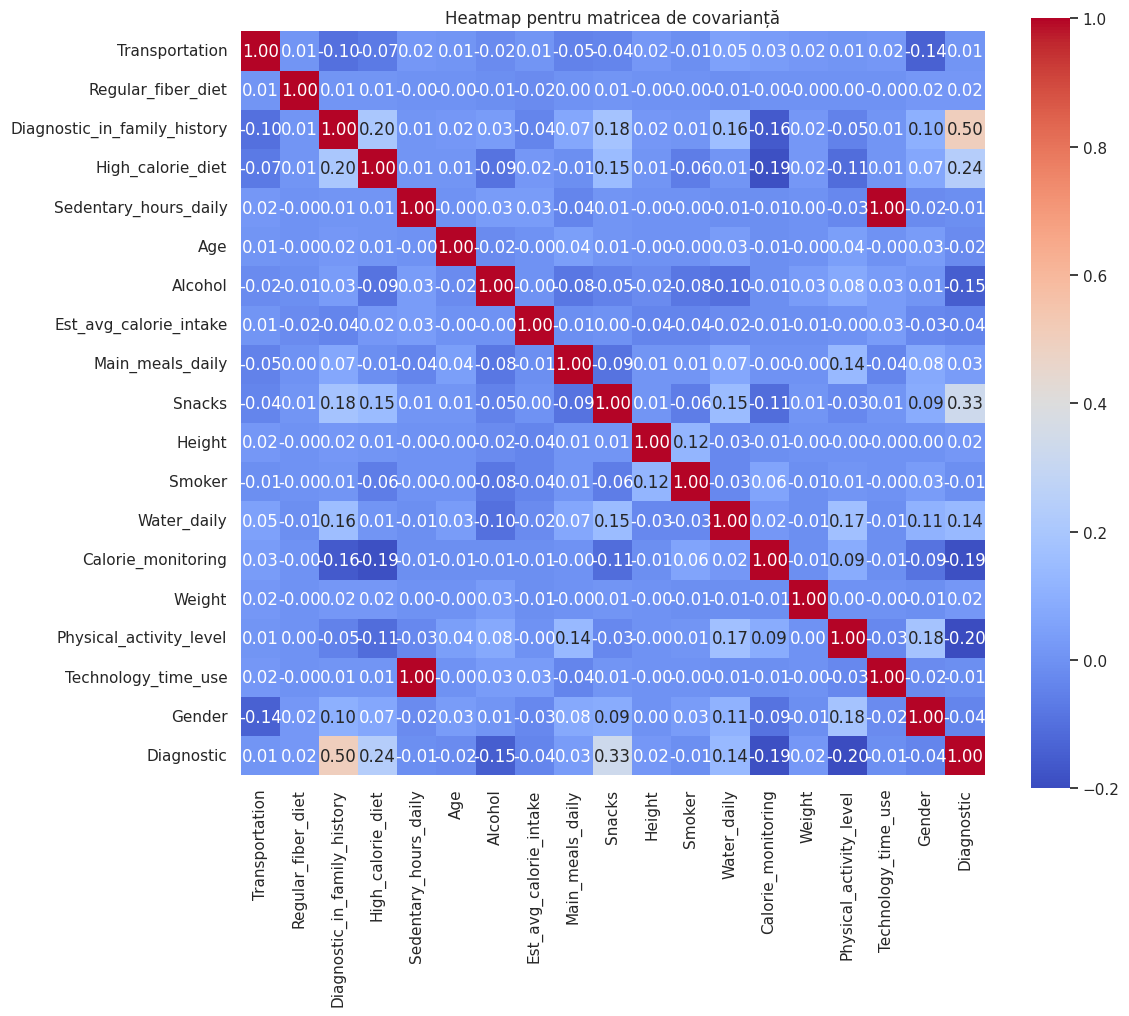

In [28]:
corr_matrix = df.corr()
rounded_corr_matrix = corr_matrix.round(2)
plt.figure(figsize=(12, 10))
sns.heatmap(rounded_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Heatmap pentru matricea de corelatie")
plt.show()


In [14]:
categorical_features = [
    "Transportation",
    "Diagnostic_in_family_history",
    "High_calorie_diet",
    "Alcohol",
    "Snacks",
    "Smoker",
    "Calorie_monitoring",
    "Gender"
]

numeric_features = [
    "Regular_fiber_diet",
    "Sedentary_hours_daily",
    "Age",
    "Est_avg_calorie_intake",
    "Main_meals_daily",
    "Height",
    "Water_daily",
    "Weight",
    "Physical_activity_level",
    "Technology_time_use",
]

def dataset_preparation():

  df = pd.read_csv(dataset)

  for col in numeric_features:
      df[col] = df[col].astype(str).str.replace(',', '.').astype(float)

  df["Weight"] = df["Weight"].replace(-1, np.nan)

  for col in categorical_features:
      df[col] = df[col].astype("category")
      le = LabelEncoder()
      df[col] = le.fit_transform(df[col])

  X = df.iloc[:, :-1]
  y = df.iloc[:, -1]
  label_encoder = LabelEncoder()
  y = label_encoder.fit_transform(y)
  x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

  # Tratăm valorile lipsă pentru atributul "Weight" cu mediana
  imputer = SimpleImputer(strategy='median')
  x_train['Weight'] = imputer.fit_transform(x_train[['Weight']])
  x_test['Weight'] = imputer.transform(x_test[['Weight']])

  # Standardizăm caracteristicile numerice
  scaler = StandardScaler()
  x_train[numeric_features] = scaler.fit_transform(x_train[numeric_features])
  x_test[numeric_features] = scaler.transform(x_test[numeric_features])

  # Aplicam VarianceThreshold
  threshold = 0.1
  selector_variance = VarianceThreshold(threshold=threshold)
  x_train_variance_selected = selector_variance.fit_transform(x_train)
  x_test_variance_selected = selector_variance.transform(x_test)

  selected_features_variance = x_train.columns[selector_variance.get_support()]

  # Definim un scor și aplicăm SelectPercentile
  percentile = 70
  selector_percentile = SelectPercentile(score_func=f_classif, percentile=percentile)
  x_train_percentile_selected = selector_percentile.fit_transform(x_train, y_train)
  selected_features_percentile = x_train.columns[selector_percentile.get_support()]

  print("Numărul total de caracteristici:", len(x_train.columns))
  print("Numărul de caracteristici selectate folosind VarianceThreshold:", len(selected_features_variance))
  print("Numărul de caracteristici selectate folosind SelectPercentile:", len(selected_features_percentile))

  removed_features_variance = set(x_train.columns) - set(selected_features_variance)
  removed_features_percentile = set(x_train.columns) - set(selected_features_percentile)

  print("Caracteristicile eliminate folosind VarianceThreshold:", removed_features_variance)
  print("Caracteristicile eliminate folosind SelectPercentile:", removed_features_percentile)
  return x_train, x_test_variance_selected, y_train, y_test, x_train_variance_selected, x_train_percentile_selected

x_train, x_test, y_train, y_test, x_train_variance, x_train_selected = dataset_preparation()

x_train = x_train_variance

Numărul total de caracteristici: 18
Numărul de caracteristici selectate folosind VarianceThreshold: 15
Numărul de caracteristici selectate folosind SelectPercentile: 12
Caracteristicile eliminate folosind VarianceThreshold: {'High_calorie_diet', 'Smoker', 'Calorie_monitoring'}
Caracteristicile eliminate folosind SelectPercentile: {'Weight', 'Technology_time_use', 'Regular_fiber_diet', 'Est_avg_calorie_intake', 'Height', 'Sedentary_hours_daily'}


In [15]:
rf_model = RandomForestClassifier(random_state=42)
rf_param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'max_samples': [0.5, 0.7, 1.0],
}

rf_grid_search = GridSearchCV(rf_model, rf_param_grid, cv=5)
rf_grid_search.fit(x_train, y_train)
rf_best_score = rf_grid_search.best_score_
rf_best_params = rf_grid_search.best_params_
print("RandomForest - Cel mai bun scor:", rf_best_score)
print("RandomForest - Cele mai bune hiper-parametri:", rf_best_params)

RandomForest - Cel mai bun scor: 0.9147193197681798
RandomForest - Cele mai bune hiper-parametri: {'max_depth': 20, 'max_samples': 1.0, 'n_estimators': 150}


In [16]:
et_model = ExtraTreesClassifier()
et_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'max_samples': [0.5, 0.7, 1.0],
    'bootstrap': [True]
}

et_grid_search = GridSearchCV(et_model, et_param_grid, cv=5)
et_grid_search.fit(x_train, y_train)
et_best_score = et_grid_search.best_score_
et_best_params = et_grid_search.best_params_
print("ExtraTrees - Cel mai bun scor:", et_best_score)
print("ExtraTrees - Cele mai bune hiper-parametri:", et_best_params)

ExtraTrees - Cel mai bun scor: 0.89388933542028
ExtraTrees - Cele mai bune hiper-parametri: {'bootstrap': True, 'max_depth': None, 'max_samples': 1.0, 'n_estimators': 200}


In [17]:
gb_model = XGBClassifier(random_state=42)
gb_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1, 0.5]}

gb_grid_search = GridSearchCV(gb_model, gb_param_grid, cv=5)
gb_grid_search.fit(x_train, y_train)
gb_best_score = gb_grid_search.best_score_
gb_best_params = gb_grid_search.best_params_
print("GradientBoostedTrees - Cel mai bun scor:", gb_best_score)
print("GradientBoostedTrees - Cele mai bune hiper-parametri:", gb_best_params)

GradientBoostedTrees - Cel mai bun scor: 0.9231926054401625
GradientBoostedTrees - Cele mai bune hiper-parametri: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}


In [18]:
svm_model = SVC()
svm_param_grid = {
    'kernel': ['linear', 'rbf', 'poly',  'sigmoid'],
    'C': [0.1, 1, 10, 100, 200, 300, 400]}

svm_grid_search = GridSearchCV(svm_model, svm_param_grid, cv=5)
svm_grid_search.fit(x_train, y_train)
svm_best_score = svm_grid_search.best_score_
svm_best_params = svm_grid_search.best_params_
print("SVM - Cel mai bun scor:", svm_best_score)
print("SVM - Cele mai bune hiper-parametri:", svm_best_params)

SVM - Cel mai bun scor: 0.6556009137442362
SVM - Cele mai bune hiper-parametri: {'C': 400, 'kernel': 'rbf'}


In [19]:
# Inițializăm modelele și grilele de căutare pentru hiper-parametri
models = {
    'RandomForest': {'model': rf_model, 'params': rf_best_params},
    'ExtraTrees': {'model': et_model, 'params': et_best_params},
    'GradientBoostedTrees': {'model': gb_model, 'params': gb_best_params},
    'SVM': {'model': svm_model, 'params': svm_best_params}
}

best_models = {
    'RandomForest': rf_grid_search.best_estimator_,
    'ExtraTrees': et_grid_search.best_estimator_,
    'GradientBoostedTrees': gb_grid_search.best_estimator_,
    'SVM': svm_grid_search.best_estimator_
}

In [20]:
def evaluate_model(model, x_test, y_test):
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average=None)
    recall = recall_score(y_test, y_pred, average=None)
    f1 = f1_score(y_test, y_pred, average=None)
    confusion = confusion_matrix(y_test, y_pred)
    return accuracy, precision, recall, f1, confusion


In [22]:
class_names = ["D0", "D1", "D2", "D3", "D4", "D5", "D6"]
# Afișăm rezultatele
print("\nTabel cu metricile de evaluare pentru fiecare algoritm:")
results = []
class_metrics = []
for name, model_info in models.items():
    model = model_info['model']
    hyperparams = model_info['params']

    # Antrenează modelul
    model.fit(x_train, y_train)

    # Evaluează modelul
    accuracy, precision, recall, f1, confusion = evaluate_model(model, x_test, y_test)

    # Salvează rezultatele generale
    results.append({'Model': name, 'Hyperparameters': hyperparams, 'Accuracy': accuracy})

    # Salvează metricile pentru fiecare clasă în parte
    for i, class_name in enumerate(class_names):
        class_metrics.append({'Model': name, 'Class': class_name,
                              'Precision': precision[i], 'Recall': recall[i], 'F1': f1[i]})

# Converteste lista de metrici de clasă în DataFrame
class_metrics_df = pd.DataFrame(class_metrics)


Tabel cu metricile de evaluare pentru fiecare algoritm:


In [25]:
results_df = pd.DataFrame(results)

# Afișăm DataFrame-ul results_df ca un tabel
display(results_df)

accuracy_mean = results_df['Accuracy'].mean()
accuracy_var = results_df['Accuracy'].var()

print("Media acurateței generale de clasificare:", accuracy_mean)
print("Varianța acurateței generale de clasificare:", accuracy_var)

,Model,Hyperparameters,Accuracy
0,RandomForest,"{'max_depth': 20, 'max_samples': 1.0, 'n_estim...",0.903896
1,ExtraTrees,"{'bootstrap': True, 'max_depth': None, 'max_sa...",0.875325
2,GradientBoostedTrees,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",0.916883
3,SVM,"{'C': 400, 'kernel': 'rbf'}",0.540260


Media acurateței generale de clasificare: 0.8090909090909091
Varianța acurateței generale de clasificare: 0.03242143138247034


In [26]:
class_metrics_df

,Model,Class,Precision,Recall,F1
0,RandomForest,D0,1.000000,0.879310,0.935780
1,RandomForest,D1,0.776119,0.928571,0.845528
2,RandomForest,D2,0.926829,0.791667,0.853933
3,RandomForest,D3,0.806452,0.909091,0.854701
4,RandomForest,D4,0.928571,0.866667,0.896552
5,RandomForest,D5,0.980769,0.944444,0.962264
6,RandomForest,D6,0.964286,1.000000,0.981818
7,ExtraTrees,D0,1.000000,0.844828,0.915888
8,ExtraTrees,D1,0.718750,0.821429,0.766667
9,ExtraTrees,D2,0.844444,0.791667,0.817204


In [27]:
# Grupăm DataFrame-ul după coloana "Class"
grouped_class_metrics = class_metrics_df.groupby('Class')

# Calculăm media și varianța pentru fiecare metrică la nivelul fiecărei clase
precision_mean = grouped_class_metrics['Precision'].mean()
precision_variance = grouped_class_metrics['Precision'].var()
recall_mean = grouped_class_metrics['Recall'].mean()
recall_variance = grouped_class_metrics['Recall'].var()
f1_mean = grouped_class_metrics['F1'].mean()
f1_variance = grouped_class_metrics['F1'].var()

# Afișăm rezultatele
print("\nMedie și varianță pentru precizie / recall / F1 la nivelul fiecărei clase în parte:")
class_metrics_summary = pd.DataFrame({
    'Precision Mean': precision_mean,
    'Precision Variance': precision_variance,
    'Recall Mean': recall_mean,
    'Recall Variance': recall_variance,
    'F1 Mean': f1_mean,
    'F1 Variance': f1_variance
})
display(class_metrics_summary)



Medie și varianță pentru precizie / recall / F1 la nivelul fiecărei clase în parte:


,Precision Mean,Precision Variance,Recall Mean,Recall Variance,F1 Mean,F1 Variance
Class,,,,,,
D0,0.913934,0.029629,0.806034,0.006812,0.854794,0.015081
D1,0.726842,0.008640,0.763393,0.069595,0.735100,0.035112
D2,0.785824,0.043765,0.671875,0.097909,0.714206,0.081065
D3,0.739436,0.026563,0.713636,0.143994,0.700594,0.101141
D4,0.772456,0.080090,0.758333,0.063796,0.764761,0.071482
D5,0.844347,0.068886,0.944444,0.000229,0.870908,0.029087
D6,0.917738,0.011048,1.000000,0.000000,0.954616,0.003667


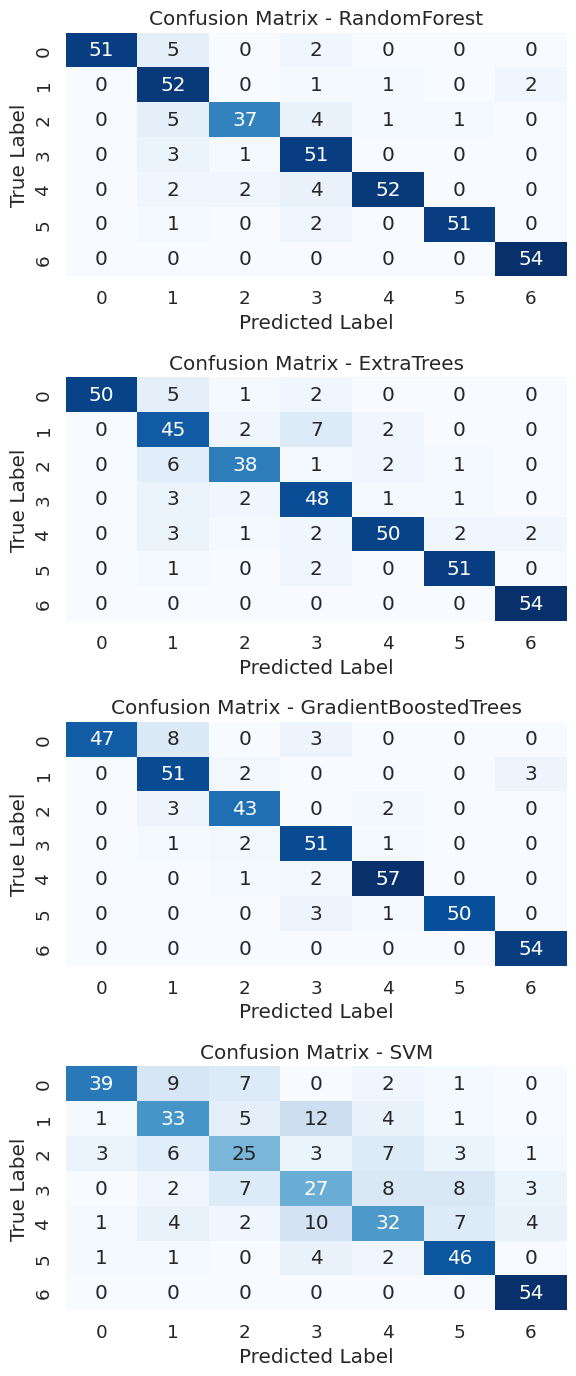

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setăm dimensiunea și fontul pentru plot
plt.figure(figsize=(6, 14))
sns.set(font_scale=1.2)

# Afișăm matricea de confuzie pentru fiecare algoritm
for i, (name, best_model) in enumerate(best_models.items(), 1):
    # Evaluează modelul
    _, _, _, _, confusion = evaluate_model(best_model, x_test, y_test)

    # Creează un subplot pentru fiecare algoritm
    plt.subplot(4, 1, i)

    # Creează heatmap pentru matricea de confuzie
    sns.heatmap(confusion, annot=True, cmap='Blues', fmt='g', cbar=False)

    # Adaugă titlu și label-uri pentru axe
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

# Adjustam layout-ul pentru a evita suprapunerea
plt.tight_layout()

# Afișăm plot-ul
plt.show()
